## Importing Modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
!pip install pyldavis

In [3]:
%%capture
!pip install contextualized-topic-models==2.3.0

In [9]:
import re
import urllib
import gzip
import io
import csv
import random
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import pickle
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import nltk
from nltk.corpus import stopwords as stop_words
nltk.download('stopwords')
import pyLDAvis as vis

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Downloading Data (Only Once)

Where to store the data file. If you want, you can adjust the path.

In [3]:
path_before_1990 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/data/titles_before_1990.txt'
path_from_1990_to_2009 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/data/titles_from_1990_to_2009.txt'
path_from_2010 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/data/titles_from_2010.txt'

Execute the following cell only once to download the data and write it as a file to your google drive. Afterwards, skip this cell or comment it out.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# to download the data manually or get more information, go to: https://dblp.org/faq/How+can+I+download+the+whole+dblp+dataset.html
url = 'https://dblp.uni-trier.de/xml/dblp.xml.gz'
# num_titles = 500000  # the (max)number of titles to load 


def load_gzip_file(url):
    """Download Gzip-file."""
    response = urllib.request.urlopen(url)
    compressed_file = io.BytesIO(response.read())
    decompressed_file = gzip.GzipFile(fileobj=compressed_file)
    return decompressed_file

def extract_titles(input_file, max_num=40000):
    """Extract title and publication year of dblp papers, given as input file.
    
    Divide the papers into 3 time periods. 
    
    Collect max max_num papers per time period.
    """
    pairs_before_1990 = []
    count_before_1990 = 0
    pairs_from_1990_to_2009 = []
    count_from_1990_to_2009 = 0
    pairs_from_2010 = []
    count_from_2010 = 0
    got_title = False
    for line in tqdm(input_file):
        line_str = line.decode('utf-8')
        if got_title: 
            # we have a title and check for the corresponding year
            year_result = re.search(r'<year>(.*)</year>', line_str)
            if year_result:
                # we also have the year and thus save the title-year pair
                year = int(year_result.group(1))
                if year < 1990:
                    pairs_before_1990.append((title, year))
                    count_before_1990 += 1
                elif year < 2010:
                    pairs_from_1990_to_2009.append((title, year))
                    count_from_1990_to_2009 += 1
                else:
                    pairs_from_2010.append((title, year))
                    count_from_2010 += 1
                got_title = False
        else:
            # we have no title and search for title
            result = re.search(r'<title>(.*)</title>', line_str)
            if result:
                title = result.group(1)
                if len(title.split(' ')) < 3:  
                    # only include titles with at least four words
                    continue
                got_title = True
        
        if count_before_1990 >= max_num and count_from_1990_to_2009 >= max_num and count_from_2010 >= max_num:
            return pairs_before_1990, pairs_from_1990_to_2009, pairs_from_2010
    
    return pairs_before_1990, pairs_from_1990_to_2009, pairs_from_2010

def save_data(pairs, file_path):
    with open(file_path, 'w') as fout:
        writer = csv.writer(fout)
        for pair in pairs:
            writer.writerow(pair)

in_file = load_gzip_file(url)
pairs_before_1990, pairs_from_1990_to_2009, pairs_from_2010 = extract_titles(in_file)
save_data(pairs_before_1990, path_before_1990)
save_data(pairs_from_1990_to_2009, path_from_1990_to_2009)
save_data(pairs_from_2010, path_from_2010)

Mounted at /content/drive


14904394it [00:39, 380034.60it/s]


## LDA

### Classes and Functions

In [162]:
path_before_1990 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/data/titles_before_1990.txt'
path_from_1990_to_2009 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/data/titles_from_1990_to_2009.txt'
path_from_2010 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/data/titles_from_2010.txt'
MODEL_path_before_1990 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/lda/lda_before_1990.pkl'
MODEL_path_from_1990_to_2009 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/lda/lda_from_1990_to_2009.pkl'
MODEL_path_from_2010 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/lda/lda_from_2010.pkl'
feature_path_before_1990 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/lda/feature_before_1990.pkl'
feature_path_from_1990_to_2009 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/lda/feature_from_1990_to_2009.pkl'
feature_path_from_2010 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/lda/feature_from_2010.pkl'

In [4]:
def load_data(path: str) -> list:
    with open(path) as fin:
        reader = csv.reader(fin)
        titles = [row[0] for row in reader]
    return titles

In [5]:
def preprocess_text(text: str) -> str:
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text

In [25]:
def vectorize(prepro_titles, num_features: int, max_df: float, min_df: int):
    tf_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, max_features=num_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(prepro_titles)
    tf_feature_names = tf_vectorizer.get_feature_names_out()
    return tf, tf_feature_names

In [26]:
def save_model(path: str, model) -> None:
    with open(path, "wb") as f:
        pickle.dump(model, f)
    return

In [27]:
def load_model_feature(model_path: str, feature_path: str):
    with open(model_path, "rb") as f:
        model = pickle.load(f)
    with open(feature_path, "rb") as f:
        feature = pickle.load(f)
    return model, feature

In [28]:
def save_feature_names(path: str, features: np.ndarray) -> None:
    with open(path, "wb") as f:
        pickle.dump(features, f)
    return

In [98]:
def lda_train(title_path, model_path, feature_path, num_lda_topics, num_features, max_df, min_df) -> None:
    titles = load_data(title_path)
    prepro_titles = [preprocess_text(title) for title in titles]
    tf, tf_feature_names = vectorize(titles, num_features=num_features, max_df=max_df, min_df=min_df)
    lda = LatentDirichletAllocation(n_components=num_lda_topics, max_iter=5, learning_method='online', random_state=42).fit(tf)
    save_model(model_path, lda)
    save_feature_names(feature_path, tf_feature_names)
    return

In [104]:
def print_top_15_words_in_a_topic(model, features) -> list:
    top_15_idx = []
    for topic_idx, topic in enumerate(model.components_):
        print("Top 15 words in topic {}".format(topic_idx+1))
        print("-"*25)
        top_15 = topic.argsort()[-15:]
        top_15_idx.append(top_15)
        print(" ".join([features[i] for i in top_15]), "\n")
    return top_15_idx

In [146]:
def prob_plot(model, feature, top_15_idx):
    x_dict = dict()
    y_dict = dict()
    for topic in range(5):
        num = str(topic + 1)
        x_dict["x"+num] = [feature[i] for i in top_15_idx[topic]]
        y_dict["y"+num] = [(model.components_ / model.components_.sum(axis=1)[:, np.newaxis])[topic][i] for i in top_15_idx[topic]]
    plt.subplot(321, frameon=True)
    plt.bar(x_dict["x1"], y_dict["y1"], color ='r')
    plt.xticks(rotation=90)
    plt.ylabel("Probability")
    plt.title("Topic 1")
    plt.subplot(322, frameon=True)
    plt.bar(x_dict["x2"], y_dict["y2"], color ='r')
    plt.xticks(rotation=90)
    plt.ylabel("Probability")
    plt.title("Topic 2")
    plt.subplot(323, frameon=True)
    plt.bar(x_dict["x3"], y_dict["y3"], color ='r')
    plt.xticks(rotation=90)
    plt.ylabel("Probability")
    plt.title("Topic 3")
    plt.subplot(324, frameon=True)
    plt.bar(x_dict["x4"], y_dict["y4"], color ='r')
    plt.xticks(rotation=90)
    plt.ylabel("Probability")
    plt.title("Topic 4")
    plt.subplot(325, frameon=True)
    plt.bar(x_dict["x5"], y_dict["y5"], color ='r')
    plt.xticks(rotation=90)
    plt.ylabel("Probability")
    plt.title("Topic 5")
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=1.6,
                        wspace=0.5,
                        hspace=3)
    plt.show()
    return

### Training

In [30]:
# Before the 1990s
lda_train(path_before_1990, MODEL_path_before_1990, feature_path_before_1990, num_lda_topics=5, num_features=10000, max_df=0.95, min_df=2)
# From 1990 to 2009
lda_train(path_from_1990_to_2009, MODEL_path_from_1990_to_2009, feature_path_from_1990_to_2009, num_lda_topics=5, num_features=10000, max_df=0.95, min_df=2)
# After 2010
lda_train(path_from_2010, MODEL_path_from_2010, feature_path_from_2010, num_lda_topics=5, num_features=10000, max_df=0.95, min_df=2)

array(['00', '01', '10', ..., 'zur', 'zvs', 'zwischen'], dtype=object)

### Analysis & Discussion

In [154]:
# LOADING MODELS
lda_1, feature_1 = load_model_feature(MODEL_path_before_1990, feature_path_before_1990)
lda_2, feature_2 = load_model_feature(MODEL_path_from_1990_to_2009, feature_path_from_1990_to_2009)
lda_3, feature_3 = load_model_feature(MODEL_path_from_2010, feature_path_from_2010)

#### Before the 1990s

In [147]:
top_15_idx_1 = print_top_15_words_in_a_topic(lda_1, feature_1)

Top 15 words in topic 1
-------------------------
estimation search synthesis research solution evaluation high structures computing chemical binary algorithms digital optimal algorithm 

Top 15 words in topic 2
-------------------------
implementation language logic languages machine multiple approach graphs circuits sup sub programming networks systems design 

Top 15 words in topic 3
-------------------------
development use methods theory dynamic logic machines sequential problems application model parallel note time control 

Top 15 words in topic 4
-------------------------
class study boolean editor error comments theorem structure using logic sets systems new linear computer 

Top 15 words in topic 5
-------------------------
pattern uuml fault data theory based processing memory recognition information network using problem systems analysis 



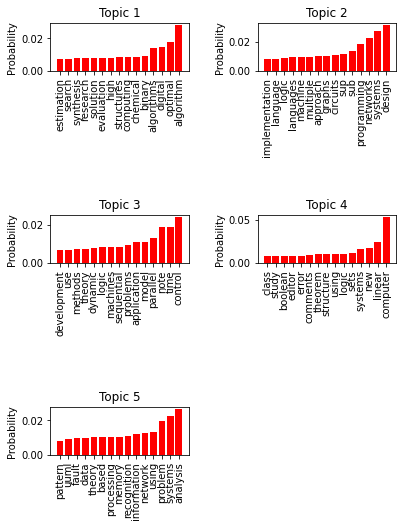

In [149]:
prob_plot(lda_1, feature_1, top_15_idx_1)

**Assign Topic Name:**

1: Algorithm Optimisation

2: Graph Algorithm

3: Control System

4: Linear Computation

5: Pattern Recognition

#### From 1990 to 2009

In [155]:
top_15_idx_2 = print_top_15_words_in_a_topic(lda_2, feature_2)

Top 15 words in topic 1
-------------------------
search use support programming frequency stochastic framework digital theory real time structure parallel management models 

Top 15 words in topic 2
-------------------------
input brain phase output comparison implementation service architecture space dimensional web dynamic sup sub design 

Top 15 words in topic 3
-------------------------
learning recognition power distributed computer image high methods study systems data using model based control 

Top 15 words in topic 4
-------------------------
efficient optimal problem application network algorithm nonlinear using based linear method time networks analysis systems 

Top 15 words in topic 5
-------------------------
research identification development software evaluation graphs fuzzy systems modeling estimation order robust adaptive information approach 



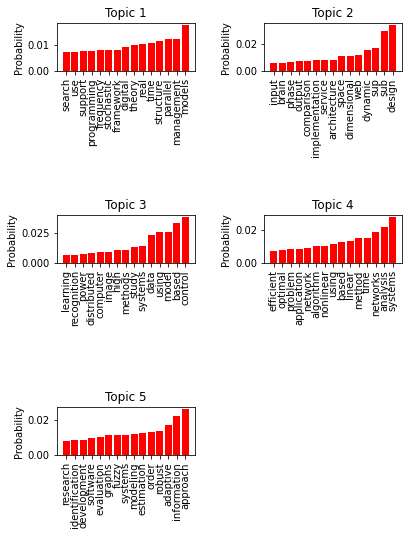

In [156]:
prob_plot(lda_2, feature_2, top_15_idx_2)

**Assign Topic Name:**

1: Parallel Stochastic Optimization Framework

2: Dynamic Software Architectures

3: Control System

4: Network Efficiency

5: Robust Estimation

#### After 2010

In [157]:
top_15_idx_3 = print_top_15_words_in_a_topic(lda_3, feature_3)

Top 15 words in topic 1
-------------------------
power efficient framework multiple deep finite mobile models dynamic energy networks systems analysis data time 

Top 15 words in topic 2
-------------------------
high methods non neural applications robust application sub optimization adaptive detection multi network based using 

Top 15 words in topic 3
-------------------------
fast feedback simulation approach large selection new linear problems modeling problem equations nonlinear design algorithm 

Top 15 words in topic 4
-------------------------
self 3d distribution dynamics communication tracking human computing sensor classification image scheme wireless estimation networks 

Top 15 words in topic 5
-------------------------
social novel state information optimal performance approach study order learning systems method model control based 



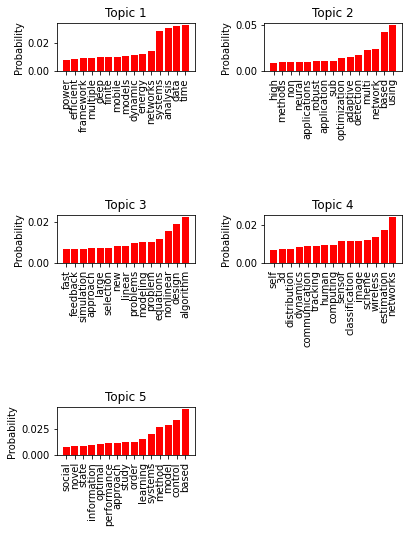

In [158]:
prob_plot(lda_3, feature_3, top_15_idx_3)

**Assign Topic Name:**

1: Deep Learning for Time-Series Data

2: Neural Network

3: Simulation Modeling

4: Computer Vision

5: Control System

## Combined Topic Models

New method developed by [Bianchi et al. 2021](https://aclanthology.org/2021.acl-short.96/). 

[A 6min presentation of the paper by one of the authors.](https://underline.io/lecture/25716-pre-training-is-a-hot-topic-contextualized-document-embeddings-improve-topic-coherence)

Code: [https://github.com/MilaNLProc/contextualized-topic-models](https://github.com/MilaNLProc/contextualized-topic-models)

Tutorial: [https://colab.research.google.com/drive/1fXJjr_rwqvpp1IdNQ4dxqN4Dp88cxO97?usp=sharing](https://colab.research.google.com/drive/1fXJjr_rwqvpp1IdNQ4dxqN4Dp88cxO97?usp=sharing)

Again, perform topic modelling for the three time periods - this time using the combined topic models (CTMs). 

You can use and adapt the code from the tutorial linked above.

Use the available GPU for faster running times.

### Classes and Functions

In [35]:
path_before_1990 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/data/titles_before_1990.txt'
path_from_1990_to_2009 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/data/titles_from_1990_to_2009.txt'
path_from_2010 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/data/titles_from_2010.txt'
MODEL_path_before_1990 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/ctm/lda_before_1990.pkl'
MODEL_path_from_1990_to_2009 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/ctm/lda_from_1990_to_2009.pkl'
MODEL_path_from_2010 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/ctm/lda_from_2010.pkl'
vocab_path_before_1990 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/ctm/vocab_before_1990.pkl'
vocab_path_from_1990_to_2009 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/ctm/vocab_from_1990_to_2009.pkl'
vocab_path_from_2010 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/ctm/vocab_from_2010.pkl'
train_path_before_1990 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/ctm/train_before_1990.pkl'
train_path_from_1990_to_2009 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/ctm/train_from_1990_to_2009.pkl'
train_path_from_2010 = '/content/drive/My Drive/ML4NLP_assignment/exercise_6/model/ctm/train_from_2010.pkl'

In [6]:
def preprocessing(data_path):
    documents = [line.strip() for line in open(data_path, encoding="utf-8").readlines()[0:2000]]
    stopwords = list(stop_words.words("english"))
    sp = WhiteSpacePreprocessingStopwords(documents, stopwords_list=stopwords)
    preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()
    tp = TopicModelDataPreparation("all-mpnet-base-v2")
    training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)
    return tp.vocab, training_dataset

In [36]:
def train_ctm(data_path, model_path, vocab_path, train_path):
    tp_vocab, training_dataset = preprocessing(data_path)
    ctm = CombinedTM(bow_size=len(tp_vocab), contextual_size=768, n_components=5, num_epochs=10)
    ctm.fit(training_dataset) # run the model
    with open(model_path, "wb") as f:
        pickle.dump(ctm, f)
    with open(vocab_path, "wb") as f:
        pickle.dump(tp_vocab, f)
    with open(train_path, "wb") as f:
        pickle.dump(training_dataset, f)
    return

In [41]:
def load_ctm(model_path, vocab_path, train_path):
    with open(model_path, "rb") as f:
        model = pickle.load(f)
    with open(vocab_path, "rb") as f:
        tp_vocab = pickle.load(f)
    with open(train_path, "rb") as f:
        training_dataset = pickle.load(f)
    return model, tp_vocab, training_dataset

In [31]:
def print_top_15_words_in_a_topic_ctm(model) -> None:
    for topic in range(5):
        print("Top 15 words in topic {}".format(str(topic+1)))
        print("-"*25)
        print(" ".join(model.get_topic_lists(15)[topic]), "\n")
    return

In [50]:
def visualisation(model, tp_vocab, training_dataset):
    lda_vis_data = model.get_ldavis_data_format(tp_vocab, training_dataset, n_samples=10)
    ctm_pd = vis.prepare(**lda_vis_data)
    return ctm_pd

### Training

In [37]:
train_ctm(path_before_1990, MODEL_path_before_1990, vocab_path_before_1990, train_path_before_1990)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: [10/10]	 Seen Samples: [19960/19960]	Train Loss: 45.62309916463787	Time: 0:00:01.769154: : 10it [00:17,  1.78s/it]
Sampling: [20/20]: : 20it [00:19,  1.04it/s]


In [38]:
train_ctm(path_from_1990_to_2009, MODEL_path_from_1990_to_2009, vocab_path_from_1990_to_2009, train_path_from_1990_to_2009)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: [10/10]	 Seen Samples: [19950/19950]	Train Loss: 35.54913954197016	Time: 0:00:01.875580: : 10it [00:19,  1.94s/it]
Sampling: [20/20]: : 20it [00:20,  1.05s/it]


In [39]:
train_ctm(path_from_2010, MODEL_path_from_2010, vocab_path_from_2010, train_path_from_2010)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: [10/10]	 Seen Samples: [19980/19980]	Train Loss: 31.06098956317157	Time: 0:00:01.798715: : 10it [00:18,  1.83s/it]
Sampling: [20/20]: : 20it [00:18,  1.06it/s]


### Analysis & Discussion

In [42]:
# LOADING MODELS
ctm_1, tp_vocab_1, training_dataset_1 = load_ctm(MODEL_path_before_1990, vocab_path_before_1990, train_path_before_1990)
ctm_2, tp_vocab_2, training_dataset_2 = load_ctm(MODEL_path_from_1990_to_2009, vocab_path_from_1990_to_2009, train_path_from_1990_to_2009)
ctm_3, tp_vocab_3, training_dataset_3 = load_ctm(MODEL_path_from_2010, vocab_path_from_2010, train_path_from_2010)

#### Before 1990

In [32]:
print_top_15_words_in_a_topic_ctm(ctm_1)

Top 15 words in topic 1
-------------------------
throughout presearch ai veith letter rejoinder pollach trade desk osis regional rlicher pragmatical psychology paradox 

Top 15 words in topic 2
-------------------------
simulation service society model stufe discourse cas prolog modeling knowledge graphics models writing fields emergence 

Top 15 words in topic 3
-------------------------
decision bibliographic libraries science journals scientific citation new world literature bibliometric productivity systems library technology 

Top 15 words in topic 4
-------------------------
architecture programming software computers processor machine computation hierarchy computer parallel pictorial protos review rom languages 

Top 15 words in topic 5
-------------------------
retrieval systems searching online services resources search effectiveness document line ed information technology text seeking 



In [53]:
ctm_1_display = visualisation(ctm_1, tp_vocab_1, training_dataset_1)
vis.display(ctm_1_display)

Sampling: [10/10]: : 10it [00:12,  1.29s/it]
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


**Assign Topic Name:**

1: None (something about libraries)

2: None (something about libraries)

3: Dynamic Planning

4: Multi-Processing

5: Text Understanding

#### From 1990 to 2010

In [33]:
print_top_15_words_in_a_topic_ctm(ctm_2)

Top 15 words in topic 1
-------------------------
encryption neural ethics attack variations key signature elliptic scheme public rsa act tumor architectures schemes 

Top 15 words in topic 2
-------------------------
digital library libraries language automation engineering software science education synthesis natural teaching interfaces user ontologies 

Top 15 words in topic 3
-------------------------
wireless ad hoc networks mobile sensor communications network lans xml wsns mobility qos query control 

Top 15 words in topic 4
-------------------------
problems optimization generalized obdd point optimal methods semi feedback proximal method solving convex programs obdds 

Top 15 words in topic 5
-------------------------
scheduling processes mediated markov stochastic communication process graph planning function routing form bius metric queueing 



In [52]:
ctm_2_display = visualisation(ctm_2, tp_vocab_2, training_dataset_2)
vis.display(ctm_2_display)

Sampling: [10/10]: : 10it [00:11,  1.18s/it]
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


**Assign Topic Name:**

1: Cryptography

2: Stochastic Optimisation

3: Wireless Sensor Network

4: Machines Translation

5: Cyber Security

#### After 2010

In [34]:
print_top_15_words_in_a_topic_ctm(ctm_3)

Top 15 words in topic 1
-------------------------
security web ambient technologies trust policy privacy information based computing providers social development access architectures 

Top 15 words in topic 2
-------------------------
management knowledge business identification risk planning key factors training continuity distributed video elliptic enterprises life 

Top 15 words in topic 3
-------------------------
deep central search generators small attack attacks function algorithm long bounding eng tcp circuit binary 

Top 15 words in topic 4
-------------------------
nerve peripheral models neural neuronal computational dependent visual interface spike model prosthesis biophysical cell channels 

Top 15 words in topic 5
-------------------------
statistical programming statistics engineering games reality computer theory augmented genetic multivariate game virtual biometric surrogate 



In [51]:
ctm_3_display = visualisation(ctm_3, tp_vocab_3, training_dataset_3)
vis.display(ctm_3_display)

Sampling: [10/10]: : 10it [00:11,  1.11s/it]
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


**Assign Topic Name:**

1: Neural Network

2: Neural Network & Bayesian

3: Cyber Security

4: Computer Vision

5: Cryptography